In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable

import data
from recurrent_attention import RecurrentAttention

## Overhead stuff

Helper functions for batching, resetting hidden states, etc.

In [2]:
# Training hyperparameters
eval_batch_size = 10
batch_size = 74
seq_len = 18
dropout = 0.1
clip = 1.5
lr = 0.02
warmup_steps = 10
decay_factor = 0.5  # Higher => faster learning rate decay
smoothing = 0.05

epochs = 50
log_interval = 150

In [3]:
# Model hyperparameters
embed_size = 512
encode_size = 256
h_size = 256
decode_size = 256
decode_out_size = 512
n_enc_layers = 2
attn_rnn_layers = 1
n_dec_layers = 2
smooth_align = True

bidirectional_attn = False

In [4]:
# Starting from sequential data, `batchify` arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.
def batchify(data, batch_size):
    # Work out how cleanly we can divide the dataset into batches
    nbatches = data.size(0) // batch_size
    # Trim off any extra elements that wouldn't cleanly fit
    data = data.narrow(0, 0, nbatches * batch_size)
    # Evenly divide the data across the batches
    data = data.view(batch_size, -1).t().contiguous()
    return data

# Wraps hidden states into new Variables to detach them from their history
def repackage_hidden(h):
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)
    
# `get_batch` subdivides the source data into chunks of the specified length.
# E.g., using the example for the `batchify` function above and a length of 2,
# we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the `batchify` function. The chunks are along dimension 0, corresponding
# to the `seq_len` dimension in the LSTM.
def get_batch(source, i, seq_len, evaluate = False):
    seq_len = min(seq_len, len(source) - 1 - i)
    data = Variable(source[i : i+seq_len], volatile = evaluate)
    target = Variable(source[i+1 : i+1+seq_len].view(-1), volatile = evaluate)
    return data, target

Label smoothing class for regularization.

In [5]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx = None, smoothing = 0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss()
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = torch.zeros_like(x.data)
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist.add_(self.smoothing / self.size)
        if self.padding_idx is not None:
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad = False)) * ntokens

Learning rate scheduler that sets the learning rate factor according to:

$$\text{lr} = d_{\text{model}}^{-0.5}\cdot\min{(\text{epoch}^{-0.5}, \text{epoch}\cdot\text{warmup}^{-1.5})}$$

This corresponds to increasing the learning rate linearly for the first $\text{warmup}$ epochs, then decreasing it proportionally to the inverse square root of the epoch number.

In [6]:
def get_lr_scheduler(h_size, warmup, optimizer):
    lrate = lambda e: h_size**(-0.5) * min((e+1)**(-decay_factor), (e+1) * warmup**(-(decay_factor+1)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lrate)

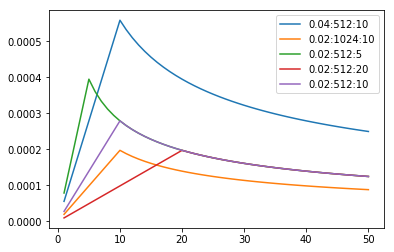

In [7]:
lrate = lambda factor, h_size, warmup: lambda e: factor*(h_size**(-0.5) * min(e**(-decay_factor), e * warmup**(-(decay_factor+1))))
opts = [
    lrate(2*lr, embed_size, warmup_steps), 
    lrate(lr, embed_size*2, warmup_steps),
    lrate(lr, embed_size, warmup_steps//2),
    lrate(lr, embed_size, warmup_steps*2),
    lrate(lr, embed_size, warmup_steps),
]
plt.plot(np.arange(1, epochs+1), [[opt(i) for opt in opts] for i in range(1, epochs+1)])
plt.legend([
    "%.4g:%d:%d" % (2*lr, embed_size, warmup_steps),
    "%.4g:%d:%d" % (lr, embed_size*2, warmup_steps),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps//2),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps*2),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps),
])

## Initialize data

In [8]:
corpus = data.Corpus('./data/ptb')
ntokens = len(corpus.dictionary)

## Model class

In [9]:
class RNNModel(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, embed_size, encode_size, h_size,
                 decode_size, decode_out_size, n_enc_layers, attn_rnn_layers,
                 n_dec_layers, align_location = False, loc_align_size = 1,
                 loc_align_kernel = 1,  smooth_align = False, bidirectional_attn = False,
                 tie_wts = True, dropout = 0.1):
        super(RNNModel, self).__init__()
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.embed_size = embed_size
        self.encode_size = encode_size
        self.h_size = h_size
        self.decode_size = decode_size
        self.decode_out_size = decode_out_size
        self.n_enc_layers = n_enc_layers
        self.attn_rnn_layers = attn_rnn_layers
        self.n_dec_layers = n_dec_layers
        self.align_location = align_location
        self.loc_align_size = loc_align_size
        self.loc_align_kernel = loc_align_kernel
        self.smooth_align = smooth_align
        self.bidirectional_attn = bidirectional_attn
        self.tie_wts = tie_wts
        self.dropout = dropout
        
        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        self.embedding = nn.Embedding(src_vocab, embed_size)
        self.encoders = nn.ModuleList([
            nn.LSTM(
                input_size = embed_size if i == 0 else encode_size,
                hidden_size = encode_size, dropout = dropout
            ) for i in range(n_enc_layers)
        ])
        self.attn = RecurrentAttention(
            in_size = encode_size, h_size = h_size, out_size = decode_size,
            align_location = align_location, loc_align_size = loc_align_size,
            loc_align_kernel = loc_align_kernel, smooth_align = smooth_align,
            num_rnn_layers = attn_rnn_layers, attn_act_fn = 'ReLU',
            dropout = dropout, bidirectional = bidirectional_attn
        )
        self.decoders = nn.ModuleList([
            nn.LSTM(
                input_size = decode_size, dropout = dropout,
                hidden_size = decode_size if i < n_dec_layers-1 else decode_out_size,
            ) for i in range(n_dec_layers)
        ])
        self.projection = nn.Linear(decode_out_size, tgt_vocab)
        if tie_wts and src_vocab == tgt_vocab and embed_size == decode_out_size:
            self.embedding.weight = self.projection.weight
        self.log_softmax = nn.LogSoftmax(dim = -1)
            
        # For visualizations
        self.save_wts = False
        self.enc_out = None
        self.dec_out = None
        
    def init(self):
        for subnet in [self.encoders, self.decoders]:
            for layer in subnet:
                for p in layer.parameters():
                    if p.dim() > 1:
                        nn.init.xavier_normal(p)
                    else:
                        p.data.fill_(0)
        for p in self.projection.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform(p)
            else:
                p.data.fill_(0)
        self.attn.init()
        
    def init_states(self, batch_size):
        encoder_states = [
            (
                Variable(torch.zeros(1, batch_size, self.encode_size)),
                Variable(torch.zeros(1, batch_size, self.encode_size))
            ) for _ in range(self.n_enc_layers)
        ]
        attn_states = self.attn.init_rnn_states(batch_size)
        decoder_states = [
            (
                Variable(torch.zeros(
                    1, batch_size, self.decode_size if i < self.n_dec_layers-1 else self.decode_out_size
                )),
                Variable(torch.zeros(
                    1, batch_size, self.decode_size if i < self.n_dec_layers-1 else self.decode_out_size
                ))
            ) for i in range(self.n_dec_layers)
        ]
        return encoder_states, attn_states, decoder_states
    
    def forward(self, inputs, states):
        enc_states, attn_states, dec_states = states
        if self.save_wts:
            self.enc_out = []
            self.dec_out = []
        
        # Embedding layer
        embeddings = self.embedding(inputs) * np.sqrt(self.embed_size)
        
        # Encoder stack
        new_enc_states = []
        enc_in = self.drop(self.relu(embeddings))
        for states, encoder in zip(enc_states, self.encoders):
            enc_out, new_enc_state = encoder(enc_in, states)
            new_enc_states.append(new_enc_state)
            if self.save_wts:
                self.enc_out.append(enc_out.data.clone())
            enc_in = enc_out
                
        # Attention mechanism
        attn_out, new_attn_states = self.attn(enc_out, attn_states)
        
        # Decoder stack
        new_dec_states = []
        dec_in = attn_out
        for states, decoder in zip(dec_states, self.decoders):
            dec_out, new_dec_state = decoder(dec_in, states)
            new_dec_states.append(new_dec_state)
            if self.save_wts:
                self.dec_out.append(dec_out.data.clone())
            dec_in = dec_out
        
        # Projection layer
        logits = self.projection(dec_out)
        output = self.log_softmax(logits)
        
        return output, (new_enc_states, new_attn_states, new_dec_states)
    
    def train(self, mode = True, save_wts = False):
        super(RNNModel, self).train(mode)
        self.attn.save_attn_wts = save_wts
        self.save_wts = save_wts
        
    def eval(self, save_wts = True):
        super(RNNModel, self).eval()
        self.attn.save_attn_wts = save_wts
        self.save_wts = save_wts

## Initialize model, criterion, optimizer, and learning rate scheduler

In [10]:
model = RNNModel(
    src_vocab = ntokens, tgt_vocab = ntokens, embed_size = embed_size,
    encode_size = encode_size, h_size = h_size, decode_size = decode_size,
    decode_out_size = decode_out_size, n_enc_layers = n_enc_layers,
    attn_rnn_layers = attn_rnn_layers, n_dec_layers = n_dec_layers,
    dropout = dropout, smooth_align = smooth_align
)
model.init()
criterion = LabelSmoothing(ntokens, smoothing = smoothing)
optimizer = optim.Adam(
    model.parameters(), lr = lr, betas = (0.9, 0.98), eps = 1e-9
)
lr_scheduler = get_lr_scheduler(embed_size, warmup_steps, optimizer)
# Reference
nparams = sum([p.numel() for p in model.parameters()])
print('Model parameters: %d' % nparams)

Model parameters: 9533969


## Train
Ready the data

In [11]:
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)
train_data.size(), val_data.size(), test_data.size()

(torch.Size([12562, 74]), torch.Size([7376, 10]), torch.Size([8243, 10]))

Define training and validation loops

In [12]:
def train():
    # Use random length sequences
    seq_lens = []
    tot_len = 0
    jitter = 0.15 * seq_len
    num_data = train_data.size(0)
    while tot_len < num_data - 2:
        if num_data - tot_len - 2 <= seq_len + jitter:
            slen = num_data - tot_len - 2
        else:
            slen = int(np.random.normal(seq_len, jitter))
            if slen <= 0:
                slen = seq_len    # eh
            if tot_len + slen >= num_data - jitter - 2:
                slen = num_data - tot_len - 2
        seq_lens.append(slen)
        tot_len += slen
    i_cumseq = [0] + list(np.cumsum(seq_lens)[:-1])
    idx = np.arange(len(seq_lens))
    np.random.shuffle(idx)
    # Turn on training mode
    model.train(save_wts = False)
    # Initialize RNN states
    states = model.init_states(batch_size)
    # Prep metainfo
    total_loss = 0
    total_epoch_loss = 0
    start_time = time.time()
    for batch, i in enumerate(idx):
        # Get training data
        data, targets = get_batch(train_data, i_cumseq[i], seq_lens[i])
        # Repackage the hidden states
        states = repackage_hidden(states)
        # Zero out gradients
        model.zero_grad()
        
        # Run the model forward
        output, _states = model(data, states)
        if np.isnan(output.data).any():
            return 0, total_epoch_loss[0], data, targets, states, _states
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets)
        if np.isnan(loss.data[0]):
            return 1, total_epoch_loss[0], data, targets, states, _states
        states = _states
        # Propagate loss gradient backwards
        loss.backward()
        # Clip gradients
        if batch % log_interval == 0 and batch > 0:
            # Save gradient statistics before they're changed cuz we'll be logging this batch
            parameters = [p for p in model.parameters() if p.grad is not None]
            # Calculate the largest (absolute) gradient of all elements in the model parameters
            max_grad = max([p.grad.data.abs().max() for p in parameters])
        total_norm = nn.utils.clip_grad_norm(model.parameters(), clip)
        # Scale the batch learning rate so that shorter sequences aren't "stronger"
        scaled_lr = lr_scheduler.get_lr()[0] * np.sqrt(seq_lens[i] / seq_len)
        for param_group in optimizer.param_groups:
            param_group['lr'] = scaled_lr
        # Update parameters
        optimizer.step()
        
        # Get some metainfo
        total_loss += loss.data
        total_epoch_loss += loss.data * data.size(0)
        if batch % log_interval == 0 and batch > 0:
            elapsed = time.time() - start_time
            cur_loss = total_loss[0] / log_interval
            print(' b {:3d}/{:3d} >> {:6.1f} ms/b | lr: {:8.2g} | grad norm: {:4.2f} | max abs grad: {:7.3f} | loss: {:4.2f} | perp.: {:6.2f}'.format(
                batch, len(seq_lens), elapsed * 1000/log_interval, scaled_lr, total_norm, max_grad, cur_loss, np.exp(cur_loss)
            ))
            total_loss = 0
            start_time = time.time()
    return -1, total_epoch_loss[0] / num_data, None, None, None, None

In [13]:
def evaluate(data_src, save_wts = True):
    model.eval(save_wts = save_wts)
    total_loss = 0
    states = model.init_states(eval_batch_size)
    for i in range(0, data_src.size(0) - 1, seq_len):
        # Get data
        data, targets = get_batch(data_src, i, seq_len, evaluate = True)
        # Repackage the hidden states
        states = repackage_hidden(states)
        # Evaluate
        output, states = model(data, states)
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets)
        total_loss += loss.data * data.size(0)
    return total_loss[0] / data_src.size(0)

Train and evaluate

In [14]:
WIDTH = 112
CAUSES = ['output', 'grad']
for epoch in range(epochs):
    lr_scheduler.step()
    print('Epoch {:3d}/{:3d}) lr = {:0.4g}{}'.format(epoch+1, epochs, np.mean(lr_scheduler.get_lr()[0]), ' (warmup)' if epoch < warmup_steps else ''))
    start_time = time.time()
    stat, train_loss, data, targets, states, nstates = train()
    if stat in list(range(len(CAUSES))):
        c = CAUSES[stat]
        n = (WIDTH - len(c) - 4) // 2
        print('\n' + (' '*n) + 'NaN ' + c)
        break
    elapsed = time.time() - start_time
    val_loss = evaluate(val_data, save_wts = False)
    max_param = max([p.data.abs().max() for p in model.parameters() if p.grad is not None])
    print('-' * WIDTH)
    print('Elapsed time: {:6.2f} sec | train_loss: {:5.2f} | train_perp: {:6.2f} | valid_loss: {:5.2f} | valid_perp.: {:6.2f}'.format(
        elapsed, train_loss, np.exp(train_loss), val_loss, np.exp(val_loss)
    ))
    print('=' * WIDTH)
    print('\n')

Epoch   1/ 50) lr = 2.795e-05 (warmup)
 b 150/727 >> 2826.7 ms/b | lr:  2.7e-05 | grad norm: 1.86 | max abs grad:   0.056 | loss: 7.86 | perp.: 2593.44
 b 300/727 >> 2654.5 ms/b | lr:  2.8e-05 | grad norm: 0.76 | max abs grad:   0.023 | loss: 6.30 | perp.: 543.79
 b 450/727 >> 2634.9 ms/b | lr:  2.9e-05 | grad norm: 0.69 | max abs grad:   0.016 | loss: 6.18 | perp.: 484.89
 b 600/727 >> 2720.8 ms/b | lr:  2.6e-05 | grad norm: 0.66 | max abs grad:   0.011 | loss: 6.16 | perp.: 475.71
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1960.42 sec | train_loss:  6.53 | train_perp: 685.59 | valid_loss:  6.13 | valid_perp.: 459.32


Epoch   2/ 50) lr = 5.59e-05 (warmup)
 b 150/712 >> 2943.3 ms/b | lr:  4.9e-05 | grad norm: 0.66 | max abs grad:   0.015 | loss: 6.21 | perp.: 497.78
 b 300/712 >> 3207.3 ms/b | lr:  5.7e-05 | grad norm: 0.56 | max abs grad:   0.010 | loss: 6.17 | perp.: 478.74
 b 450/712 >> 3093.4 ms/b 

 b 150/717 >> 2665.0 ms/b | lr:  0.00027 | grad norm: 1.44 | max abs grad:   0.036 | loss: 5.03 | perp.: 152.88
 b 300/717 >> 2598.5 ms/b | lr:  0.00029 | grad norm: 1.51 | max abs grad:   0.032 | loss: 4.98 | perp.: 145.03
 b 450/717 >> 2706.0 ms/b | lr:  0.00024 | grad norm: 2.58 | max abs grad:   0.062 | loss: 4.94 | perp.: 140.09
 b 600/717 >> 2752.1 ms/b | lr:  0.00024 | grad norm: 2.10 | max abs grad:   0.048 | loss: 4.98 | perp.: 146.13
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1934.84 sec | train_loss:  4.97 | train_perp: 143.82 | valid_loss:  5.75 | valid_perp.: 314.47


Epoch  12/ 50) lr = 0.0002552
 b 150/711 >> 2656.8 ms/b | lr:  0.00026 | grad norm: 2.16 | max abs grad:   0.055 | loss: 4.96 | perp.: 143.28
 b 300/711 >> 2611.9 ms/b | lr:  0.00024 | grad norm: 3.58 | max abs grad:   0.106 | loss: 4.81 | perp.: 122.16
 b 450/711 >> 2696.6 ms/b | lr:  0.00028 | grad norm: 6.23 | max abs grad:

 b 300/718 >> 2711.6 ms/b | lr:  0.00018 | grad norm: 2.80 | max abs grad:   0.146 | loss: 3.78 | perp.:  43.63
 b 450/718 >> 2579.4 ms/b | lr:   0.0002 | grad norm: 2.34 | max abs grad:   0.048 | loss: 3.64 | perp.:  38.03
 b 600/718 >> 2570.9 ms/b | lr:  0.00019 | grad norm: 2.56 | max abs grad:   0.082 | loss: 3.66 | perp.:  39.04
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1899.63 sec | train_loss:  3.79 | train_perp:  44.39 | valid_loss:  3.44 | valid_perp.:  31.21


Epoch  22/ 50) lr = 0.0001884
 b 150/716 >> 2635.6 ms/b | lr:  0.00017 | grad norm: 2.47 | max abs grad:   0.063 | loss: 3.89 | perp.:  48.91
 b 300/716 >> 2587.4 ms/b | lr:   0.0002 | grad norm: 3.62 | max abs grad:   0.148 | loss: 3.69 | perp.:  40.22
 b 450/716 >> 2654.2 ms/b | lr:  0.00018 | grad norm: 8.57 | max abs grad:   0.255 | loss: 3.82 | perp.:  45.54
 b 600/716 >> 2757.4 ms/b | lr:  0.00021 | grad norm: 2.34 | max abs grad:

 b 450/714 >> 2624.7 ms/b | lr:  0.00016 | grad norm: 3.96 | max abs grad:   0.118 | loss: 3.26 | perp.:  26.15
 b 600/714 >> 2697.2 ms/b | lr:  0.00016 | grad norm: 8.71 | max abs grad:   0.304 | loss: 3.01 | perp.:  20.38
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1956.95 sec | train_loss:  3.08 | train_perp:  21.81 | valid_loss:  3.39 | valid_perp.:  29.65


Epoch  32/ 50) lr = 0.0001563
 b 150/719 >> 2877.3 ms/b | lr:  0.00015 | grad norm: 4.04 | max abs grad:   0.123 | loss: 3.11 | perp.:  22.53
 b 300/719 >> 2757.6 ms/b | lr:  0.00016 | grad norm: 6.90 | max abs grad:   0.189 | loss: 2.88 | perp.:  17.86
 b 450/719 >> 2650.0 ms/b | lr:  0.00015 | grad norm: 3.51 | max abs grad:   0.139 | loss: 2.80 | perp.:  16.37
 b 600/719 >> 2631.6 ms/b | lr:  0.00017 | grad norm: 7.35 | max abs grad:   0.239 | loss: 2.92 | perp.:  18.56
--------------------------------------------------------------------------

 b 600/719 >> 2680.4 ms/b | lr:  0.00014 | grad norm: 8.22 | max abs grad:   0.192 | loss: 2.63 | perp.:  13.92
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1907.91 sec | train_loss:  2.60 | train_perp:  13.49 | valid_loss:  2.14 | valid_perp.:   8.53


Epoch  42/ 50) lr = 0.0001364
 b 150/713 >> 2703.9 ms/b | lr:  0.00015 | grad norm: 6.93 | max abs grad:   0.238 | loss: 2.92 | perp.:  18.52
 b 300/713 >> 2582.4 ms/b | lr:  0.00012 | grad norm: 2.78 | max abs grad:   0.081 | loss: 2.48 | perp.:  11.97
 b 450/713 >> 2715.9 ms/b | lr:  0.00012 | grad norm: 12.25 | max abs grad:   0.760 | loss: 2.52 | perp.:  12.41
 b 600/713 >> 2710.8 ms/b | lr:  0.00013 | grad norm: 3.12 | max abs grad:   0.100 | loss: 2.44 | perp.:  11.51
----------------------------------------------------------------------------------------------------------------
Elapsed time: 1905.87 sec | train_loss:  2.58 | train_perp:  13.20 | val

In [ ]:
WIDTH = 112
CAUSES = ['output', 'grad']
for epoch in range(epochs, 2*epochs):
    lr_scheduler.step()
    print('Epoch {:3d}/{:3d}) lr = {:0.4g}{}'.format(epoch+1, 2*epochs, np.mean(lr_scheduler.get_lr()[0]), ' (warmup)' if epoch < warmup_steps else ''))
    start_time = time.time()
    stat, train_loss, data, targets, states, nstates = train()
    if stat in list(range(len(CAUSES))):
        c = CAUSES[stat]
        n = (WIDTH - len(c) - 4) // 2
        print('\n' + (' '*n) + 'NaN ' + c)
        break
    elapsed = time.time() - start_time
    val_loss = evaluate(val_data, save_wts = False)
    max_param = max([p.data.abs().max() for p in model.parameters() if p.grad is not None])
    print('-' * WIDTH)
    print('Elapsed time: {:6.2f} sec | train_loss: {:5.2f} | train_perp: {:6.2f} | valid_loss: {:5.2f} | valid_perp.: {:6.2f}'.format(
        elapsed, train_loss, np.exp(train_loss), val_loss, np.exp(val_loss)
    ))
    print('=' * WIDTH)
    print('\n')

Epoch  51/100) lr = 0.0001238
 b 150/714 >> 4085.1 ms/b | lr:  0.00013 | grad norm: 14.93 | max abs grad:   0.701 | loss: 2.45 | perp.:  11.60
 b 300/714 >> 3442.0 ms/b | lr:  0.00014 | grad norm: 3.59 | max abs grad:   0.117 | loss: 2.06 | perp.:   7.86
 b 450/714 >> 3377.8 ms/b | lr:  0.00012 | grad norm: 3.71 | max abs grad:   0.125 | loss: 2.04 | perp.:   7.68
 b 600/714 >> 3419.3 ms/b | lr:  0.00014 | grad norm: 14.27 | max abs grad:   0.565 | loss: 2.05 | perp.:   7.77
----------------------------------------------------------------------------------------------------------------
Elapsed time: 2543.86 sec | train_loss:  2.19 | train_perp:   8.90 | valid_loss:  3.17 | valid_perp.:  23.86


Epoch  52/100) lr = 0.0001226
 b 150/720 >> 3346.7 ms/b | lr:  0.00012 | grad norm: 5.19 | max abs grad:   0.117 | loss: 2.21 | perp.:   9.15
 b 300/720 >> 3354.1 ms/b | lr:  0.00012 | grad norm: 6.72 | max abs grad:   0.318 | loss: 2.18 | perp.:   8.85
 b 450/720 >> 3329.8 ms/b | lr:  0.00013 |

 b 300/717 >> 3455.7 ms/b | lr:  0.00012 | grad norm: 4.85 | max abs grad:   0.243 | loss: 1.60 | perp.:   4.96
 b 450/717 >> 3482.0 ms/b | lr:  0.00011 | grad norm: 5.70 | max abs grad:   0.234 | loss: 1.65 | perp.:   5.22
 b 600/717 >> 3496.6 ms/b | lr:  0.00011 | grad norm: 5.93 | max abs grad:   0.230 | loss: 2.41 | perp.:  11.17
----------------------------------------------------------------------------------------------------------------
Elapsed time: 2484.43 sec | train_loss:  1.82 | train_perp:   6.14 | valid_loss:  1.44 | valid_perp.:   4.21


Epoch  62/100) lr = 0.0001123
 b 150/725 >> 3555.5 ms/b | lr:  0.00011 | grad norm: 2.71 | max abs grad:   0.138 | loss: 1.58 | perp.:   4.86
 b 300/725 >> 3346.0 ms/b | lr:  0.00012 | grad norm: 5.44 | max abs grad:   0.185 | loss: 1.57 | perp.:   4.79
 b 450/725 >> 3370.8 ms/b | lr:  0.00011 | grad norm: 2.90 | max abs grad:   0.153 | loss: 1.59 | perp.:   4.93
 b 600/725 >> 3453.6 ms/b | lr:  0.00011 | grad norm: 3.44 | max abs grad:

In [ ]:
if stat in list(range(len(CAUSES))):
    params = [p for p in model.parameters() if p.grad is not None]
    print(any([np.isnan(p.data).any() for p in params]), any([np.isnan(p.grad.data).any() for p in params]))
    
    enc_states, attn_states, dec_states = states
    relu = nn.ReLU()
    log_softmax = nn.LogSoftmax(dim = -1)
    
    embeddings = model.embedding(data)
    enc_out, new_enc_states = model.encoder(model.drop(embeddings))
    attn_out, new_attn_states = model.attn(enc_out, attn_states)
    dec_out, new_dec_states = model.decoder(relu(attn_out))
    output = model.projection(dec_out)
    
    print([
        np.isnan(p.data).any() for p in [embeddings, enc_out, attn_out, dec_out, output]
    ])

In [ ]:
test_loss = evaluate(test_data, save_wts = True)
print('test_loss: {:5.2f} | test_perplexity: {:5.2f}'.format(
    test_loss, np.exp(test_loss)
))

## Evaluate predictions

In [ ]:
nb = 4
model.eval(save_wts = True)
# Get some data from a random point in the test_data set
states = model.init_states(nb)
data, targets = get_batch(test_data, 120, seq_len, evaluate = True)
data = data[:,:nb].contiguous()
targets = targets.view(seq_len, -1)[:,:nb].contiguous()

In [ ]:
# Run the model forward
output, states = model(data, states)
# Convert the output log probabilities to normal probabilities
output = output.exp()
# Get the argmax of each step in the output
output_p, output_idx = output.max(dim = -1)

Compare the predicted output word indices to the targets

In [ ]:
targets = targets.t()
output_idx = output_idx.t()
for i in range(nb):
    # Print the output with the targets
    seqs = torch.cat([targets[i].unsqueeze(0), output_idx[i].unsqueeze(0)], 0)
    # Number incorrectly predicted
    num_incorrect = (targets[i] != output_idx[i]).sum()
    print('%d incorrectly predicted\n' % num_incorrect[0], seqs)

Interestingly, some of the predicted subsequences are correct, but temporally shifted. Some other subsequences duplicate a predicted word two or more times, resulting in either incorrect predictions for those duplicated words, or the immediately following subsequence being "correct", but actually incorrect because it's now in the wrong temporal position.

These errors feel like they'd be caused by the attention mechanism failing to properly attend to the "important" parts of the sequence at each step during. Not sure if this is due to the attention mechanism failing, or if something about the encoder and/or decoder messing with it.

## Visualizations
List of modules in the model for reference:

In [ ]:
modules = list(model.modules())
list(enumerate(modules))

Some basic weight heat maps to start:

In [ ]:
embed_wts = np.array(modules[3].weight.data)
embed_norm = (embed_wts - embed_wts.mean()) / (embed_wts.max() - embed_wts.min())
plt.imshow(embed_norm, aspect = 'auto', cmap = 'jet')
plt.xlabel('dim'); plt.ylabel('word index');
plt.title('Embedding layer')
plt.colorbar()
embed_wts.shape

In [ ]:
attn = modules[7]

In [ ]:
attn_wts = np.array(attn.attention.weight.data)
attn_norm = (attn_wts - attn_wts.mean()) / (attn_wts.max() - attn_wts.min())
plt.imshow(attn_norm, aspect = 'auto', cmap = 'jet')
plt.xlabel('d_input+d_state+d_output'); plt.ylabel('d_output')
plt.title('Output attention sublayer (in attention mechanism)')
plt.colorbar()
attn_wts.shape

Sequence attention visualization by mapping the alignment weights (in the attention mechanism) at each step of the input:

In [ ]:
cols = 2
rows = nb//cols
fig, axs = plt.subplots(rows, cols, figsize = (30, 20))
for b in range(nb):
    wts = attn.attn_wts[:,b,:]
    wts_mean = wts.mean()
    wts_max = wts.max()
    wts_min = wts.min()
    norm = (wts - wts_mean) / (wts_max - wts_min)
    r = b // cols
    c = b % cols
    ax = axs[r, c]
    im = ax.imshow(wts, aspect = 'auto', cmap = 'jet')
    # Fix labels
    xlabels = list(targets[b].data)
    ax.set_xticks(range(seq_len))
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('Targets')
    ylabels = list(data[:,b].data)
    ax.set_yticks(range(seq_len))
    ax.set_yticklabels(ylabels)
    ax.set_ylabel('Inputs')
    ax.set_title('Example %d' % b)
    fig.colorbar(im, ax = ax)
plt.show()

I wonder if the fact that the encoder and decoder both are 2-stacks of LSTMs is causing the odd shapes of these attention heatmaps. Since the later layers of an LSTM stack tend to encode longer-term temporal dependencies, feeding the attention mechanism the outputs to the last layer of the encoder stack might be causing the attention mechanism to look at longer-term dependencies and ignoring shorter-term ones. Need to test out a model that has skip connections from the previous layer's output to the next layer's output.